# A Toy example

## Problem formulation
### Background: A Toy Example
Let’s consider the following example: we plan to conduct a study on the height of people in our neighborhood. We will walk around the neighborhood and record the height, in centimeters, of each person we encounter. To model the height data, we use a normal likelihood as the data-generating model, with average height $\mu$ and random variation $\sigma$. Furthermore, to keep the example as simple as possible, we ignore any individual differences. Thus, our model has two parameters $\theta$ and can be formalized as follows:
$$
\begin{align*}
    \theta &:= (\mu, \sigma)\\
    height_i &\sim \text{Normal}(\mu, \sigma)
\end{align*}
$$
As we have prior knowledge about the expected $height_i$​ and would like to incorporate this information into our model, we choose a Bayesian modeling approach. This approach allows us to include our prior knowledge by specifying prior distributions for the model parameters: 
$$
\theta \sim p(\theta).
$$
The challenge is that our prior knowledge pertains to $height_i$ (i.e., the outcome variable), but we need to specify prior distributions for $\theta$ (i.e., the model parameters). 
+ $\mathcal Q$: Which prior distributions for the model parameters accurately reflects our prior knowledge on the outcome variable? $[p(\theta) = ??]$

### Prior elicitation method
*Prior elicitation methods* are designed to translate expert information into corresponding prior distributions for the model parameters. We will focus on a specific group of prior elicitation methods that address specifically the following translation problem: the expert provides information about the outcome variable (here: $height_i$) and we need a translation of this information to prior distributions $p(\theta)$ that correctly reflect this knowledge. To understand this point, it helps to think generatively. Suppose we specify particular prior distributions $p(\mu)$ and $p(\sigma)$. To assess whether these priors reflect our knowledge, we can sample values from them: $\sigma^{S} \sim p(\sigma)$ and $\mu^{S} \sim p(\mu)$. Next, we plug these sampled values into our likelihood and simulate data: $height_i^{S} \sim \text{Normal}(\mu^{S}, \sigma^{S})$. Finally, we can ask ourselves: Do these simulated data $height_i^{S}$​ align with our expectations about $height_i$, then the set of select prior distributions correctly reflects our prior knowledge.


We offer two different approaches, which we refer to as *parametric prior* and *deep prior*.
#### Approach 1: Parametric Prior
In this approach the user needs to specify a parametric prior distribution family for each model parameter parameterized by $\lambda$. The user could for example specify the following prior distribution families for $\theta$:
$$
\begin{align*}
\mu &\sim \text{Normal}(\mu_\mu, \sigma_\mu)\\
\sigma &\sim \text{Gamma}(\alpha, \beta)\\
\lambda &:= (\mu_\mu, \sigma_\mu, \alpha, \beta)
\end{align*}
$$
#### Approach 2: Deep Prior 
In this approach no further specifications from the user are needed, as in this approach a joint prior distribution for the model parameters is learned via normalizing flows (a generative approach that uses deep neural networks, see REF for details):
$$
(\mu, \sigma) \sim p_\lambda(\cdot)
$$

### The Problem revisited (informal)
Thus, while the *parametric prior* method learns point values (as represented by the vector $\lambda$), the *deep prior* method learns a function (the join prior distribution). However, for both methods we can reformulate $\mathcal Q$ in terms of: 
+ $\mathcal Q^*$: Which hyperparameter values $\lambda$ yield a prior distribution for $\theta$ that accurately represents the prior knowledge about $height_i$?

While in the *parametric prior* method $\lambda$ refers to the hyperparameter values $(\mu_\mu, \sigma_\mu, \alpha, \beta)$, in the *deep prior* method, $\lambda$ refers to the weights of the neural networks used to learn the function. 

### Elicit Expert Information
Before we can start using our method, we need first to get the expert information. A common approach to get expert information about the expected distribution of a target quantity (here: $height_i$) is to query the expert with respect to different quantiles $Q_p$, e.g. the 25% quantile of the expected distribution of $height_i$, $Q_{25\%}(height_i)$. Such that we end-up with a set of expert information, called the *elicited statistics*, $t_m$. Whereby we denote the expert elicited statistics by $\hat t_m$:
+ $\hat t_1 = Q_{5\%}(height_i)$
+ $\hat t_2 = Q_{25\%}(height_i)$
+ $\hat t_3 = Q_{50\%}(height_i)$
+ $\hat t_4 = Q_{75\%}(height_i)$
+ $\hat t_5 = Q_{95\%}(height_i)$

### The Problem revisited (more formal)
As we have the data-generating model, we can simulate from this model, after creating some random initial values for $\lambda$.
First, we sample from the prior distributions $\theta' \sim p(\theta \mid \lambda^{ini})$, and then we sample from the likelihood, $y' \sim p(y \mid \theta)$. The distribution of the resulting $y' \sim p(y)$, reflects the *prior predictive distribution*. From this simulated distribution, we can finally compute the corresponding quantiles $Q_p(y')$ and get the simulation-based elicited statistics, $t_m$.
Having the expert and simulation-based elicited statistics, we can finally compare how strong their discrepancy is, $L_m(t_m(\lambda), \hat t_m)$,
where $L$ refers to an appropriate discrepancy measure or **L**oss function. 
As we want to evaluate the discrepancy for each elicited statistic, we end up in a multi-objective loss function:
$$
\sum_{m=1}^M\alpha_m L_m(t_m(\lambda),\hat t_m)
$$
As our goal is to find $\lambda$ which corresponds to the expert information $\hat t$, our goal is in other words to minimize the multi-objective loss function:
$$
\lambda_\min := \arg \min_\lambda \sum_{m=1}^M\alpha_m L_m(t_m(\lambda),\hat t_m).
$$
## Expert information
Query quartiles of the expected outcome variable $y_i$:



In [1]:
import tensorflow_probability as tfp
import tensorflow as tf
import pandas as pd
import sys

tfd = tfp.distributions 

from functions.loss_functions import MMD_energy
from setup.input_functions import param, model, target, loss, expert, optimization, prior_elicitation, normalizing_flow_specs


C:\Users\bockting\AppData\Local\anaconda3\envs\elicit_env\lib\site-packages\bayesflow\trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
class Model:
    def __call__(self, ground_truth, prior_samples):

        # data-generating model
        likelihood = tfd.Normal(loc=prior_samples[:,:,0],
                                scale=prior_samples[:,:,1])
        # prior predictive distribution
        ypred = likelihood.sample()
        
        return dict(likelihood = likelihood,     
                    ypred = ypred,                 
                    epred = None,
                    prior_samples = prior_samples                 
                    )
    

<AxesSubplot:ylabel='Density'>

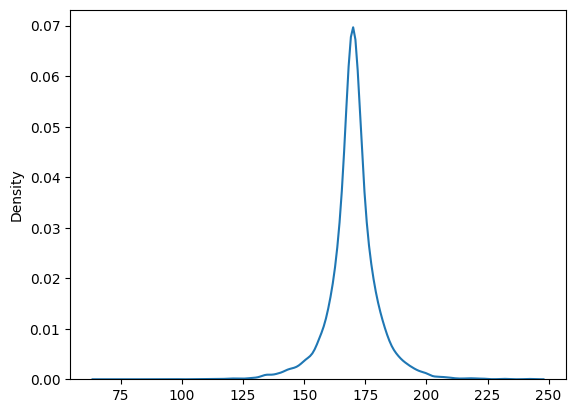

In [23]:
mu = tfd.Normal(170,2).sample(10000)
sigma = tfd.HalfNormal(10).sample(10000)
x = tfd.Normal(mu, sigma).sample()

import seaborn as sns

sns.kdeplot(x)

In [2]:
# modelling the data
## model parameters
def model_params():  
        return (
            param(name = "mu", 
                  family=tfd.Normal,
                  hyperparams_dict={
                      "mu_mu": tfd.Uniform(100.,200.),
                      "sigma_mu": tfd.Uniform(1., 30)
                      }),
            param(name = "sigma", 
                  family=tfd.HalfNormal,
                  hyperparams_dict={
                      "mu_sigma": tfd.Uniform(1.,50.)
                      })
            )

## data-generating model
from user_input.generative_models import Model
def generative_model():
    return model(Model,
                 discrete_likelihood = False,
                 additional_model_args = None
                )
def expert_input():
        return expert(data=None,
                      simulate_data = True,
                      simulator_specs = {
                         "mu": tfd.Normal(170., 2.),
                         "sigma": tfd.HalfNormal(10.),
                         },
                     rep = 10000
                      ) 
# elicited information
def target_quantities():
        return (
            target(name = "ypred",
                    elicitation_method = "quantiles",
                    quantiles_specs=(5, 25, 50, 75, 95),
                    loss_components = "by-group"
                    ),
            )   
#%% Loss function
def loss_function():
    return loss(loss_function = MMD_energy,
                loss_weighting = None
                )
    
#%% Training settings
def optimization_settings():
    return optimization(
                    optimizer = tf.keras.optimizers.Adam,
                    optimizer_specs = {
                        "learning_rate": 0.05,  
                        "clipnorm": 1.0
                        }
                    )
    
##% global method function
prior_elicitation(
    method = "parametric_prior",
    sim_id = "toy",
    B = 128,
    rep = 400,
    seed = [0,1,3,4],
    burnin = 100,
    epochs = 500,
    output_path = "results",
    param_independence = {
        "independent": True,
        "loss-scaling": 0.1
        },
    model_params = model_params,
    expert_input = expert_input,
    generative_model = generative_model,
    target_quantities = target_quantities,
    loss_function = loss_function,
    optimization_settings = optimization_settings,
    view_ep = 50,
    print_info = True
    )

Parallelization is used with 4 cores.


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.5min remaining:  1.5min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.5min finished


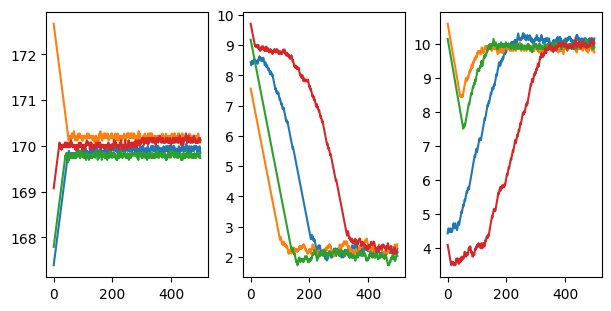

In [3]:
import matplotlib.pyplot as plt

path = "elicit/simulations/results/data/parametric_prior/"

_, axs = plt.subplots(1,3, constrained_layout=True, figsize=(6,3))
for file in [f"toy_{i}" for i in range(4)]:
    axs[0].plot(pd.read_pickle(path+file+"/final_results.pkl")["hyperparameter"]["mu_mu"])
    axs[2].plot(pd.read_pickle(path+file+"/final_results.pkl")["hyperparameter"]["mu_sigma"])
    axs[1].plot(pd.read_pickle(path+file+"/final_results.pkl")["hyperparameter"]["sigma_mu"])